In [1]:
import argparse
import datetime
import pathlib
import json
import yaml

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from tqdm import tqdm
from ml_collections import ConfigDict

from core.dataset import COCODatasetWithID
from core.config import save_config
from core.model import Model
from core.metrics import AccuracyLogger, IndividualScoreLogger

In [2]:
import pickle

In [9]:
with open('args_test.p','rb') as F:
    args = pickle.load(F)

In [89]:
args.annotations = '../openrooms/annotation_files/scannet_handmade_cleaned_test_set_4_categories_redone.json'

In [90]:
args.annotations

'../openrooms/annotation_files/scannet_handmade_cleaned_test_set_4_categories_redone.json'

In [91]:
args.config

'config.yaml'

In [92]:
import os

In [93]:
# with open('args_test.p','wb') as F:
#     pickle.dump(args, F)
assert(args.checkpoint is not None), "A checkpoint needs to be specified via commandline argument (--checkpoint)"
assert(args.config is not None), "A config needs to be specified via commandline argument (--config)"

with open(os.path.join(args.outdir,args.config)) as f:
    cfg = ConfigDict(yaml.load(f, Loader=yaml.Loader))

cfg.checkpoint = args.checkpoint

if args.annotations is not None:
    cfg.test_annotations = args.annotations
if args.imagedir is not None:
    cfg.test_imagedir = args.imagedir
if args.uncertainty_threshold is not None:
    cfg.uncertainty_threshold = args.uncertainty_threshold
if args.uncertainty_gate_type is not None:
    cfg.uncertainty_gate_type = args.uncertainty_gate_type
if args.weighted_prediction is not None:
    cfg.weighted_prediction = args.weighted_prediction

assert(cfg.test_annotations is not None), "Annotations need to be specified either via commandline argument (--annotations) or config (test_annotations)."
assert(cfg.test_imagedir is not None), "Imagedir needs to be specified either via commandline argument (--imagedir) or config (test_imagedir)."

if not hasattr(cfg, "num_classes"): # infer number of classes
    with open(cfg.annotations) as f:
        NUM_CLASSES = len(json.load(f)["categories"])
    cfg.num_classes = NUM_CLASSES

In [94]:
pathlib.Path(args.outdir).mkdir(exist_ok=True, parents=True)
save_config(cfg, args.outdir)
print(cfg)

print("Initializing model from checkpoint {}".format(args.checkpoint))
checkpoint = torch.load(os.path.join(args.outdir,args.checkpoint), map_location="cpu")
model = Model.from_config(cfg)
missing_keys, unexpected_keys = model.load_state_dict(checkpoint['model_state_dict'], strict=False)



annotations: ../openrooms/annotation_files/handmade_and_train_4_categories_main_xml_50_v3_.json
batch_size: 15
blur_context: 0
blur_target: 0
checkpoint: checkpoint_50.tar
cnn_baseline: false
git: 2179780af36e53218cf9f25623959fb36ae2379d
imagedir: ../
imbalance_reweighting: false
learning_rate: 1.0e-05
num_classes: 4
num_decoder_heads: 8
num_decoder_layers: 6
pretrained: false
test_annotations: ../openrooms/annotation_files/scannet_handmade_cleaned_test_set_4_categories_redone.json
test_imagedir: ../
uncertainty_gate_type: learned
uncertainty_threshold: 0.8
vit_baseline: false
weighted_prediction: true

Initializing model from checkpoint checkpoint_50.tar
Not using pretrained features for encoder.


/n/home05/smadan/.conda/envs/domain_adaptation/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home05/smadan/.conda/envs/domain_adaptation/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Not using pretrained features for encoder.


In [95]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device);

In [96]:
annotations_file = cfg.test_annotations
imagedir = cfg.imagedir

In [97]:
testset = COCODatasetWithID(annotations_file, imagedir, (224,224), normalize_means=[0.485, 0.456, 0.406], normalize_stds=[0.229, 0.224, 0.225])
dataloader = DataLoader(testset, batch_size=10, num_workers=1, shuffle=True, drop_last=False)

-------------------------------
Annotation Counts
-------------------------------
chair                       163
table                        56
sofa                         53
desk                          6
Total                       278
-------------------------------



In [98]:
with torch.no_grad():
    for i, (context_images, target_images, bbox, labels_cpu, annotation_ids) in enumerate(tqdm(dataloader, desc="Test Batches", leave=True)):
        context_images = context_images.to(device)
        target_images = target_images.to(device)
        bbox = bbox.to(device)
        labels = labels_cpu.to(device) # keep a copy of labels on cpu to avoid unnecessary transfer back to cpu later
        break

Test Batches:   0%|          | 0/28 [00:01<?, ?it/s]


In [99]:
import matplotlib.pyplot as plt

In [100]:
%matplotlib inline

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


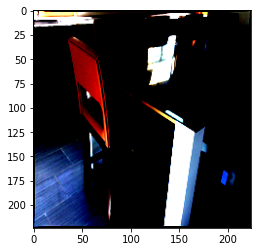

In [101]:
plt.imshow(context_images[7].detach().permute(1,2,0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


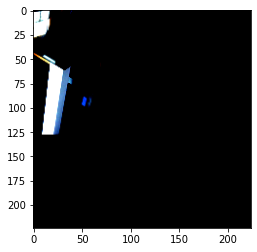

In [102]:
plt.imshow(target_images[7].detach().permute(1,2,0))
plt.show()

In [26]:
# def test(model, annotations_file, imagedir, outdir, outname="test", epoch=None, record_individual_scores=False, print_batch_metrics=False):
#     """
#     Arguments:
#         epoch: If specified, it is used to include the epoch in the output file name.
#     """
    

    
#     testset = COCODatasetWithID(annotations_file, imagedir, (224,224), ['main_xml1'], normalize_means=[0.485, 0.456, 0.406], normalize_stds=[0.229, 0.224, 0.225])
#     dataloader = DataLoader(testset, batch_size=1, num_workers=1, shuffle=False, drop_last=False)

#     if print_batch_metrics:
#         criterion = nn.CrossEntropyLoss()

#     test_accuracy = AccuracyLogger(testset.idx2label)

#     if record_individual_scores:
#         individual_scores = IndividualScoreLogger(testset.idx2label)
    
#     model.eval() # set eval mode
#     with torch.no_grad():
#         for i, (context_images, target_images, bbox, labels_cpu, annotation_ids) in enumerate(tqdm(dataloader, desc="Test Batches", leave=True)):
#             context_images = context_images.to(device)
#             target_images = target_images.to(device)
#             bbox = bbox.to(device)
#             labels = labels_cpu.to(device) # keep a copy of labels on cpu to avoid unnecessary transfer back to cpu later

#             output = model(context_images, target_images, bbox) # output is (batchsize, num_classes) tensor of logits
#             _, predictions = torch.max(output.detach().to("cpu"), 1) # choose idx with maximum score as prediction
#             test_accuracy.update(predictions, labels_cpu)

#             if record_individual_scores:
#                 individual_scores.update(predictions.to("cpu"), labels_cpu, annotation_ids)

#             # print
#             if print_batch_metrics:
#                 batch_loss = criterion(output, labels).item()
#                 batch_corr = sum(predictions == labels_cpu) # number of correct predictions
#                 batch_accuracy = batch_corr # / batch_size # since batchsize is 1

#                 print("\t Test Batch {}: \t Loss: {} \t Accuracy: {}".format(i, batch_loss, batch_accuracy))
        
#     print("\nTotal Test Accuracy: {}".format(test_accuracy.accuracy()))
#     print("{0:20} {1:10}".format("Class", "Accuracy")) # header
#     for name, acc in test_accuracy.named_class_accuarcies().items():
#         print("{0:20} {1:10.4f}".format(name, acc))

#     # save accuracies
#     if epoch is not None:
#         test_accuracy.save(outdir, name="{}_accuracies_epoch_{}".format(outname, epoch))
#     else:
#         test_accuracy.save(outdir, name="{}_accuracies".format(outname))

#     if record_individual_scores:
#         individual_scores.save(outdir, name="{}_individual_scores".format(outname))

#     return test_accuracy

In [27]:
# pathlib.Path(args.outdir).mkdir(exist_ok=True, parents=True)
# save_config(cfg, args.outdir)
# print(cfg)

# print("Initializing model from checkpoint {}".format(args.checkpoint))
# checkpoint = torch.load(args.checkpoint, map_location="cpu")
# model = Model.from_config(cfg)
# missing_keys, unexpected_keys = model.load_state_dict(checkpoint['model_state_dict'], strict=False)

# assert not missing_keys, "Checkpoint is missing keys required to initialize the model: {}".format(missing_keys)
# if len(unexpected_keys):
#     print("Checkpoint contains unexpected keys that were not used to initialize the model: ")
#     print(unexpected_keys)

# model.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))

# test(model, cfg.test_annotations, cfg.test_imagedir, args.outdir, outname=args.outname, record_individual_scores=args.record_individual_scores , print_batch_metrics=args.print_batch_metrics)